Este notebook muestra cómo hacer procesamiento de lenguaje natural representando los textos mediante bolsas de palabras (es decir, vectores de términos) y usando técnicas cuantitativas.

En él veremos cómo clasificar textos con algoritmos clásicos de aprendizaje automático.


*Este notebook reutiliza y modifica el siguiente notebook [NLP Town](http://www.nlp.town) [disponible en github](https://github.com/nlptown/nlp-notebooks/blob/master/Traditional%20text%20classification%20with%20Scikit-learn.ipynb) y utiliza como referencia la siguiente web [Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41)

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

%matplotlib inline

# Ejemplo de corpus de documentos


In [3]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus,
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


# Pre-procesamiento simple

---



Un tipo de preprocesamiento o normalización habitual consiste en eliminar caracteres especiales, pasar a minúsculas y eliminar palabras vacías.
Este procesamiento se puede realizar utilizando la librería [nltk](https://www.nltk.org/)

In [4]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

# Clasificación de textos mediante bolsa de palabras

---



El primer paso será transformar cada texto en un vector de variables descriptivas y, por tanto, el conjunto de textos pasará a ser una matriz de datos donde por columnas tengamos las variables de entrada y por filas cada uno de los textos del conjunto. Además habrá una columna indicando la clase del texto, es decir, el tema del grupo de noticias al que pertenece el texto.

Seguiremos la aproximación de la "bolsa-de-palabras". Cada texto, será transformado en un vector de palabras con su frecuencia de aparición en el texto. El orden de aparición deja de ser relevante. Las palabras que no aparecen en dicho texto, pero sí en otros del conjunto de datos, tendrán frecuencia cero.



En Scikit-learn, podemos construir esa matriz de datos con `CountVectorizer`, que transforma el texto en variables, donde cada variable es una palabra, y cuenta las veces que aparece dicha palabra en el corpus de documentos. Si no le facilitamos un diccionario (en nuestro caso no lo hará), las variables que extraerá serán aquellas palabras encontradas analizando el corpus. Estos son algunos de los parámetros más importantes:
- `analyzer`: en nuestro caso usaremos palabras, y por tanto el valor por defecto que es `word`
- `lowercase`: valor booleano para indicar se convierten todos los caracteres a minúsculas. Por defecto vale `True`.
- `binary`: es un valor booleano que si está a `True` indica que la bolsa de palabras solamente refleja si un término está presente o ausente, mientras que si está a `False` (opción por defecto) indica que se contabilizará la frecuencia de dicho término.
- `vocabulary`: le facilita la lista de términos que se van a usar (términos del vector) en forma de diccionario de Python (clave son los términos y el valor, el índice de la matriz) o en forma de un objeto iterable (p.ej. una lista). Si no se da este parámetro, el vocabulario se construye en base a los términos del corpus.
- `stop_words`: hay que pasar una lista o el string 'english' que es la única lista de palabras que maneja sklearn (es imperfecta).
- `ngram_range`: el rango de los n-gramas que se van a extraer, si queremos solamente monogramas usamos `(1,1)`, que es la opción por defecto.
- `max_df` y `min_df`: sirve para ignorar palabras cuya frecuencia en el corpus de documentos sea mayor que el número indicado, es decir, identifica palabras tan frecuentes en el corpus que no discriminan. Por el contario, `min_df` elimina términos muy infrecuentes del corpus para reducir la dimensionalidad.
- `max_features`: indica el número de términos máximo que se usará, para ello filtra el top de la lista ordenada de mayor a menor frecuencia.


El `CountVectorizer` nos devuelve un vector de términos con valores binarios (indicando la presencia de términos en un documento) o valores enteros positivos indicando su frecuencia (según el parámetro `binary`).


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [6]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,0
3,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
7,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0


# TF-IDF Model

Sin embargo, la frecuencia de un término en un documento puede no ser muy útil ya que contendrá palabras que son muy frecuentes en inglés y no necesariamente stop-words, que las hemos podido eliminar, sino palabras como *like*, *think*, *have*. Estas palabras no tienen un gran poder discriminante, como si lo tendrían en este caso palabras como  *computer* o *hardware*: palabras que son frecuentes en textos de una clase, pero no de otras.  

Para matizar la frecuencia de un término según lo específico o general que sea se utiliza el TF-IDF. Esto suele ser más útil que la frecuencia en bruto en contextos de recuperación de información o clasificación. El TF-IDF cuenta el número de veces que una palabra aparece en un texto, divido entre el logaritmo del porcentaje de documentos del corpus que contienen dicho término. Para poder generar estos pesos se puede utilizar `TfidfTransform` sobre el resultado obtenido por un `CountVectorizer`, o utilizar directamente `TfidfVectorizer`.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer()
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


# Similitud entre documentos

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


## Conjunto de datos

El conjunto de datos que vamos a utilizar es el de [20 Newsgroups](http://qwone.com/~jason/20Newsgroups/), que es usado a menudo como benchmark para modelos de clasificación de textos y que se encuentra disponible en [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html).

El conjunto consiste en textos sobre diferentes temas, desde hardware hasta religión. Algunos temas están muy relacionados, p.ej. "IBM PC hardware" y "Mac hardware", mientras que otros son más diversos, p.ej. "religion" o "hockey").

Está dividido de forma predeterminada en entrenamiento (train) y prueba (test) en porcentajes de 60 y 40, respectivamente.

In [9]:
from sklearn.datasets import fetch_20newsgroups

train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

print("Temas: ", train_data.target_names)

Training texts: 11314
Test texts: 7532
Temas:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Siempre es adecuado observar el texto de partida con el que vamos a trabajar, ya que nos permite anticipar posibles problemas o limitaciones.

In [10]:
print(train_data.data[10])
print("Tema: ", train_data.target_names[train_data.target[10]])

From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
-------------------------------------------------------------------

In [11]:
print(train_data.data[1000])
print("Tema: ", train_data.target_names[train_data.target[1000]])

From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov

Tema:  comp.os.ms-windows.misc


## Preprocesado de datos

### Ajustando la bolsa de palabras en entrenamiento

En primer lugar aplicaremos las transformaciones en el conjunto de entrenamiento. Observa que tanto el diccionario usado, como la frecuencia inversa de aparición de un término en los documentos (es decir, el término IDF), debe ser el mismo en los conjuntos de entrenamiento y de test. Los datos de test son datos que simulan el funcionamiento del algoritmo entrenado, por tanto no son conocidos en tiempo de entrenamiento.


Por ello, debemos usar el método `fit_transform` para el conjunto de entrenamiento,  para fijar el diccionario en `CountVectorizer` y el término idf del `TfidfTransformer`, mientras que usaremos simplemente el método `transform` en el conjunto de test (de forma que ambas herramientas usan lo aprendido en el conjunto de entrenamiento).

Dicho de otra forma la función `fit_transform` hace dos pasos: primero ajusta `fit` y luego transforma `transform`. En los datos de entrenamiento corresponde hacer los dos pasos.

#### Intento 1: Obteniendo la frecuencia de los términos de los documentos con un diccionario inferido del conjunto de entrenamiento

En primer lugar vamos a generar la bolsa de palabras con TF-IDF.

El primer paso es obtener las frecuencias de las palabras con `CountVectorizar` y lo haremos usando el diccionario que se inferirá de los términos de los documentos que se le pasan al `CountVectorizer` (esta opción es el funcionamiento por defecto por tanto no hay que hacer nada).  También queremos usar la lista de palabras que proporciona sklearn para el inglés (parámetro `stop_words` con el valor `english`).

In [12]:
vectorizer = CountVectorizer(stop_words='english')
# Tomamos los textos del conjunto de entrenamiento y los transformamos en
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(train_data.data)

Vamos a ver cómo han quedado los términos con los parámetros por defecto y cuántos términos hay.


In [13]:
feature_names = vectorizer.get_feature_names_out()

print(len(feature_names))

129796


In [14]:
print(feature_names[:100])
print(feature_names[-100:])

['00' '000' '0000' '00000' '000000' '00000000' '0000000004' '0000000005'
 '00000000b' '00000001' '00000001b' '0000000667' '00000010' '00000010b'
 '00000011' '00000011b' '0000001200' '00000074' '00000093' '000000e5'
 '00000100' '00000100b' '00000101' '00000101b' '00000110' '00000110b'
 '00000111' '00000111b' '00000315' '000005102000' '00000510200001'
 '000007' '00000ee5' '00001000' '00001000b' '00001001' '00001001b'
 '00001010' '00001010b' '00001011' '00001011b' '000010af' '00001100'
 '00001100b' '00001101' '00001101b' '00001110' '00001110b' '00001111'
 '00001111b' '000021' '000042' '000062david42' '000094' '0000vec' '0001'
 '00010000' '00010000b' '00010001' '00010001b' '00010010' '00010010b'
 '00010011' '00010011b' '000100255pixel' '00010100' '00010100b' '00010101'
 '00010101b' '00010110' '00010110b' '00010111' '00010111b' '00011000'
 '00011000b' '00011001' '00011001b' '00011010' '00011010b' '00011011'
 '00011011b' '00011100' '00011100b' '00011101' '00011101b' '00011110'
 '00011110b' '

In [15]:
print(train_vector_data[10])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 74 stored elements and shape (1, 129796)>
  Coords	Values
  (0, 111094)	1
  (0, 90192)	1
  (0, 75888)	1
  (0, 83103)	1
  (0, 114195)	1
  (0, 40419)	1
  (0, 111466)	1
  (0, 72244)	1
  (0, 47916)	1
  (0, 119441)	1
  (0, 33477)	1
  (0, 75863)	1
  (0, 75757)	1
  (0, 89911)	1
  (0, 124791)	1
  (0, 51190)	1
  (0, 76233)	1
  (0, 87002)	1
  (0, 55501)	1
  (0, 61849)	1
  (0, 6475)	1
  (0, 68389)	4
  (0, 40589)	2
  (0, 76537)	2
  (0, 90177)	2
  :	:
  (0, 89369)	2
  (0, 94786)	1
  (0, 8042)	1
  (0, 25566)	1
  (0, 106753)	1
  (0, 115875)	1
  (0, 74886)	1
  (0, 108498)	1
  (0, 33252)	2
  (0, 90996)	1
  (0, 122921)	1
  (0, 11976)	1
  (0, 114453)	1
  (0, 12963)	1
  (0, 109903)	1
  (0, 79638)	1
  (0, 32450)	1
  (0, 69372)	1
  (0, 30836)	1
  (0, 83757)	1
  (0, 116618)	1
  (0, 63785)	1
  (0, 48354)	1
  (0, 1410)	1
  (0, 98627)	1



Vamos a ver los términos extraídos para los mensajes de antes.

In [16]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.

    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0

    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))

    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])

    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [17]:
#write_terms(feature_names, train_data.data, train_vector_data, 10)
write_terms(feature_names, None, train_vector_data, 10)

write_terms(feature_names, None, train_vector_data, 1000)

Mensaje 10 vectorizado: ['00' '05' '0826' '13' '17k' '1978' '1993' '1st' '3495' '3k' '900gts'
 'accel' 'arnstein' 'axis' 'beemer' 'bike' 'bit' 'bronze' 'brown' 'clock'
 'cmptrc' 'computrac' 'distribution' 'dod' 'duc' 'ducati' 'email'
 'expires' 'faded' 'fix' 'gmt' 'gts' 'hard' 'honk' 'irwin' 'jap'
 'keywords' 'leak' 'leaks' 'like' 'line' 'lines' 'll' 'lonestar' 'mate'
 'model' 'motors' 'nice' 'oil' 'opinions' 'orange' 'org' 'organization'
 'owner' 'paint' 'pops' 'r75' 'recommendation' 'richardson' 'runs' 'sat'
 'shop' 'sold' 'stable' 'subject' 'summary' 'thanks' 'thinking' 'trans'
 'tuba' 'tx' 'usa' 'want' 'worth'] 

Mensaje 1000 vectorizado: ['10' '1024x768x256' 'anybody' 'bbs' 'cursor' 'dabl2' 'delivered'
 'diamond' 'distortion' 'don' 'driver' 'drivers' 'email' 'gateway' 'going'
 'gov' 'indication' 'know' 'latest' 'lhc' 'library' 'lindbergh' 'lines'
 'medicine' 'menus' 'mouse' 'national' 'nih' 'nlm' 'organization' 'post'
 'recently' 'running' 'seen' 'sorry' 'ss24x' 'subject' 'try' 'v

Como observamos mucho ruido, incluido términos numéricos y alfanuméricos, vamos a probar una opción mucho más restrictiva que sería usar únicamente las palabras de un diccionario.

Es posible que esos términos clasifiquen bien, pero no por las razones correctas. Por otro lado, usando otra herramienta más sofisticada que ``CountVectorizer`` podríamos inferir un mejor diccionario. O puliendo la lista de palabras eliminando términos numéricos y alfanuméricos.

#### Intento 2: Obteniendo la frecuencia de los términos de los documentos con un diccionario elaborado previamente

En este segundo intento vamos a usar el diccionario que se encuentra en la siguiente URL y que debéis bajar para usar este notebook.
https://github.com/dwyl/english-words/blob/master/words.txt
    
Al usar un diccionario sucede lo siguiente:
- Los términos serán únicamente los presentes en el diccionario por lo que tenemos más control sobre ellos
- El diccionario no incluirá términos que pueden aparecer en el texto, y esto puede quitar ruido, pero elimina jerga específica que no figura en el diccionario.
    
El diccionario será una lista de términos que se le pasará al `CountVectorizer` a través del parámetro `vocabulary`. En este caso volveremos a usar la lista de palabras vacías que proporciona sklearn para el inglés (parámetro `stop_words=english`).

Como queremos usar TF-IDF una vez obtenida la frecuencia de los términos para este nuevo diccionario, vamos a usar `TfidfTransformer` para matizarla según lo frecuente que sea ese término en el conjunto de textos de entremiento.

El primer paso es configurar el nuevo `CountVectorizer` con el diccionario del archivo `words.txt`.

In [18]:
# acceso a google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Pasamos el fichero a una lista (una línea por item)


# with open('/content/drive/MyDrive/IA2/p3/words.txt') as f:
#    dictionary = f.read().splitlines()
with open('/content/drive/MyDrive/Colab Notebooks/IA2/PLN/words.txt') as f:
    dictionary = f.read().splitlines()

# El diccionario cargado lo pasamos en el parámetro vocabulary
vectorizer = CountVectorizer(vocabulary=dictionary, stop_words='english')

Vamos a ver cuántos términos hay en el diccionario, veremos que hay muchos más términos en un diccionario de propósito general que en uno inferido de un corpus de textos sobre un pequeño subconjunto de temas.

Recuerda que esto no quiere decir que el diccionario cargado contenga todos los términos del diccionario inferido porque este puede tener palabras propias (jerga, nombres comerciales, etc) y términos alfanuméricos que también observamos.

In [20]:
feature_names = vectorizer.get_feature_names_out()

print(len(feature_names))
print(feature_names[:100])

466550
['2' '1080' '&c' '10-point' '10th' '11-point' '12-point' '16-point'
 '18-point' '1st' '2,4,5-t' '2,4-d' '20-point' '2D' '2nd' '30-30' '3D'
 '3-D' '3M' '3rd' '48-point' '4-D' '4GL' '4H' '4th' '5-point' '5-T' '5th'
 '6-point' '6th' '7-point' '7th' '8-point' '8th' '9-point' '9th' 'a' "a'"
 'a-' 'A&M' 'A&P' 'A.' 'A.A.A.' 'A.B.' 'A.B.A.' 'A.C.' 'A.D.' 'A.D.C.'
 'A.F.' 'A.F.A.M.' 'A.G.' 'A.H.' 'A.I.' 'A.I.A.' 'A.I.D.' 'A.L.' 'A.L.P.'
 'A.M.' 'A.M.A.' 'A.M.D.G.' 'A.N.' 'a.p.' 'a.r.' 'A.R.C.S.' 'A.U.'
 'A.U.C.' 'A.V.' 'a.w.' 'A.W.O.L.' 'A/C' 'A/F' 'A/O' 'A/P' 'A/V' 'A1'
 'A-1' 'A4' 'A5' 'AA' 'AAA' 'AAAA' 'AAAAAA' 'AAAL' 'AAAS' 'Aaberg'
 'Aachen' 'AAE' 'AAEE' 'AAF' 'AAG' 'aah' 'aahed' 'aahing' 'aahs' 'AAII'
 'aal' 'Aalborg' 'Aalesund' 'aalii' 'aaliis']


In [21]:
train_vector_data = vectorizer.fit_transform(train_data.data)

print(train_vector_data[10])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 35 stored elements and shape (1, 466550)>
  Coords	Values
  (0, 9)	1
  (0, 1757)	1
  (0, 41737)	2
  (0, 51946)	1
  (0, 75059)	1
  (0, 110476)	1
  (0, 132559)	1
  (0, 134102)	1
  (0, 140287)	1
  (0, 167355)	1
  (0, 179840)	1
  (0, 205586)	1
  (0, 214232)	1
  (0, 214251)	1
  (0, 217830)	1
  (0, 218698)	1
  (0, 242689)	1
  (0, 246394)	1
  (0, 268031)	2
  (0, 270494)	1
  (0, 271432)	2
  (0, 271492)	1
  (0, 280042)	1
  (0, 281363)	1
  (0, 329668)	1
  (0, 345594)	1
  (0, 363663)	1
  (0, 374159)	1
  (0, 381303)	1
  (0, 389037)	1
  (0, 391936)	1
  (0, 404000)	1
  (0, 405633)	1
  (0, 413750)	1
  (0, 453619)	1


In [22]:
from sklearn.feature_extraction.text import TfidfTransformer

# Calculamos el valor TF-IDF

tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

print(train_preprocessed[10])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 35 stored elements and shape (1, 466550)>
  Coords	Values
  (0, 9)	0.1546573210769761
  (0, 1757)	0.24025986195025265
  (0, 41737)	0.2696064986160778
  (0, 51946)	0.22040579018131543
  (0, 75059)	0.14466852420361814
  (0, 110476)	0.07039468372127293
  (0, 132559)	0.15839393154203713
  (0, 134102)	0.2446752570443342
  (0, 140287)	0.15044873822346275
  (0, 167355)	0.10282469952662125
  (0, 179840)	0.2364350727468518
  (0, 205586)	0.0995147942571766
  (0, 214232)	0.20618616432687353
  (0, 214251)	0.21320729780394218
  (0, 217830)	0.061493407198908376
  (0, 218698)	0.028737188053314357
  (0, 242689)	0.1322423432567627
  (0, 246394)	0.1985755300061289
  (0, 268031)	0.317734772936509
  (0, 270494)	0.10641429257432347
  (0, 271432)	0.21437906522262262
  (0, 271492)	0.029797887417882633
  (0, 280042)	0.15228548086648813
  (0, 281363)	0.16942679765389695
  (0, 329668)	0.20618616432687353
  (0, 345594)	0.13281332636741827
  (0, 363663

Vamos a mostrar los términos presentes en los mensajes de antes


In [23]:
#write_terms(feature_names, train_data.data, train_vector_data, 10)
write_terms(feature_names, None, train_vector_data, 10)

write_terms(feature_names, None, train_vector_data, 1000)

Mensaje 10 vectorizado: ['1st' 'accel' 'bike' 'bronze' 'clock' 'distribution' 'expires' 'faded'
 'fix' 'hard' 'honk' 'keywords' 'leak' 'leaks' 'like' 'lines' 'model'
 'motors' 'oil' 'opinions' 'org' 'organization' 'owner' 'paint'
 'recommendation' 'runs' 'shop' 'sold' 'stable' 'subject' 'summary'
 'thanks' 'thinking' 'trans' 'want'] 

Mensaje 1000 vectorizado: ['anybody' 'bbs' 'cursor' 'delivered' 'distortion' 'driver' 'drivers'
 'gateway' 'indication' 'know' 'latest' 'library' 'lines' 'medicine'
 'menus' 'organization' 'recently' 'running' 'sorry' 'subject' 'try'
 'version' 'wondered'] 



Ahora no observamos  ruido en las palabras seleccionadas, aunque hemos perdido palabras de jerga como ``bit``, ``sdk``, ``Ducati`` o ``jap`` (abreviatura de japanese) que podrían ser útiles para discriminar mejor los temas.

Por tanto nos quedamos con la bolsa de palabras generada por este segundo intento y será la que usemos para entrenar a nuestros clasificadores.

Para probar los clasificadores en el conjunto de prueba, debemos transformar también los mensajes en bolsas de palabras con TF/IDF usando el `CountVectorizer` y `TfidfTransformer` ajustados con el conjunto de entrenamiento.

In [24]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer.transform(test_data.data)
# Calculamos el valor TF-IDF
# Al usar "transform" toma como IDF el del conjunto de entrenamiento
test_preprocessed=tfidfer.transform(test_vector_data)

## Entrenando los modelos de aprendizaje automático

Vamos a probar los clasificadores que ya conocemos en el problema de clasificación de textos.

La versión que vamos a usar de los clasificadores es la versión por defecto. Sin embargo, es posible encontrar mejores clasificadores buscando combinaciones de parámetros más adecuadas durante el aprendizaje.

### Árbol de decisión

In [25]:
from sklearn import tree
import numpy as np

# Creamos el clasificador con los valores por defecto
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_preprocessed, train_data.target)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == train_data.target))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == test_data.target))

Árbol, porcentaje de aciertos en entrenamiento: 0.9998232278592893
Árbol, porcentaje de aciertos en test: 0.4766330323951142


Podemos ver un fuerte sobre-aprendizaje, por lo que es conveniente mejorar el árbol modificando los parámetros de entrenamiento para que aumente la capacidad de generalización del árbol.

### k Vecinos Más Cercanos (k-NN)

La implementación de sklearn de K-NN no permite usar la disimilaridad del coseno (1-similitud del coseno) porque no es propiamente una distancia. Tampoco podemos usar el coeficiente de Jaccard porque no está implementado para matrices dispersas. Por tanto, usamos la distancia euclídea (por defecto), aunque no sea adecuada para espacios de tantas dimensiones.

In [26]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_preprocessed, train_data.target)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_data.target))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_data.target))

k-NN, porcentaje de aciertos en entrenamiento: 0.8679512108891638
k-NN, porcentaje de aciertos en test: 0.6255974508762613


Según los resultados es posible que se pueda encontrar parámetros para que la diferencia entre el error de entrenamiento y test no sea tan acusada.

No obstante, el k-NN no es una técnica adecuada para este tipo de problemas donde las variables son del orden de los millares (palabras diferentes en el corpus) ya que sufre de la maldición de la dimensionalidad. Intenta buscar vecinos en un espacio de dimensiones muy elevado y además muy escasamente poblado (*sparsity*). En este caso el problema es muy significativo ya que el número de instancias de entrenamiento (11.314) es incluso menor que el número de dimensiones que se usa para representarlas (466.551).

### Naive Bayes

El clasificador [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) es un clasificador probabilístico muy simple y muy poderoso en este (y otros) contextos.

El clasificador se llama "naive" es decir "ingenuo" porque asume que todas las variables son independientes entre sí. En este caso, que la ocurrencia de una palabra en un texto es independiente del resto de palabras. Esto no es así (en un texto de hardware es probable encontrar palabras como "CPU" y "motherboard", mientras que en uno de religión encontraremos "pray" y "God"). Pese a esta gran simplificación de la realidad el clasificador funciona muy bien.

El clasificador aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, el clasificador estima la probabilidad de que pertenezca a cada una de las clases y elige la más alta.
Los clasificadores Naive Bayes Classifiers se entrenan muy rápido, pero no son los mejores. Suelen ser utilizados como clasificadores de referencia.


Existen tres tipos de Naive Bayes que se suelen utilizar en PLN según el tipo de problema:

 - __Naive Bayes Multinomial__ que se utiliza cuando las variables son enteras (como el número de apariciones de cada palabra en el documento) pero también se "traga" datos con decimales (como el valor TF/IDF). No admite números negativos.
     - En algunos problemas, como en el análisis de sentimiento (*sentiment analysis*) de un texto, lo importante puede ser la presencia o ausencia de palabras que indiquen un sentimiento positivo o negativo, y no tanto su frecuencia. En estos casos se puede utilizar una versión binarizada del Naive Bayes Multinomial basada en la representación binarizada de los vectores bolsa de palabras (CountVectorizer con el parámetro binary=True).

- __Naive Bayes Gaussiano__ que se utiliza cuando la variable que interesa es continua (por ejemplo TF/IDF). Admite valores positivos y negativos.

- __Naive Bayes Bernoulli__ que se utiliza cuando es la ausencia de determinadas palabras la que importa. Por tanto, suele ser adecuado para clasificar documentos cortos (menos variedad de palabras) y para identificar contenido muy específico como SPAM y contenido adulto.

Vamos a trabajar con el **NB Multinomial**.

In [27]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, train_data.target)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == train_data.target))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == test_data.target))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9178009545695598
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.7412373871481678


## Evaluación detallada

Vamos a analizar el rendimiento del **Naive Bayes multinomial**.

En un problema de clasificación multiclase suele ser muy interesante analizar dos cosas:
 - El rendimiento de la clasificación en cada una de las clases
 - La matriz de confusión

Lo primero nos permite analizar en qué clases funciona mejor o peor el clasificador, de acuerdo a métricas como la precisión (cuando predice dicha clase cuánto acierta) y la exhaustividad  (cuántos ejemplos de una clase predice correctamente). También podemos ver la media (armònica) entre ambas medidas (F1 score).

La matriz nos permite ver qué clases se confunden más entre sí y si dicha confusión es simétrica o no.
    

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions = mnb_test_predictions

print(classification_report(test_data.target, predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.44      0.57       319
           comp.graphics       0.66      0.69      0.67       389
 comp.os.ms-windows.misc       0.65      0.63      0.64       394
comp.sys.ibm.pc.hardware       0.55      0.72      0.63       392
   comp.sys.mac.hardware       0.73      0.59      0.65       385
          comp.windows.x       0.75      0.74      0.75       395
            misc.forsale       0.88      0.72      0.79       390
               rec.autos       0.87      0.86      0.86       396
         rec.motorcycles       0.88      0.87      0.87       398
      rec.sport.baseball       0.93      0.88      0.91       397
        rec.sport.hockey       0.91      0.95      0.93       399
               sci.crypt       0.66      0.95      0.78       396
         sci.electronics       0.76      0.63      0.69       393
                 sci.med       0.92      0.81      0.86       396
         

En el caso del Naive Bayes Multinomial hay clases que se clasifican muy bien, como `rec.sport.hockey`, `rec.sport.baseball` y `rec.motorcycles`.

Sin embargo, es interesante que hay clases como `talk.religion.misc` con una precisión muy alta y una exhaustividad muy bajo, y por otro lado clases donde sucede lo contrario, aunque no tan acusado, como en `soc.religion.christian`.

La exhaustividad muy baja indica que esos textos tienden a confundirse mucho con otros. Una precisión baja por el contrario quiere decir que el clasificador no ha sido capaz de encontrar rasgos distintivos para dichos textos que los diferencien de otros.

Podemos echar un vistazo más a la matriz de confusión para entender mejor este problema.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0.5, 0, 'alt.atheism'),
  Text(1.5, 0, 'comp.graphics'),
  Text(2.5, 0, 'comp.os.ms-windows.misc'),
  Text(3.5, 0, 'comp.sys.ibm.pc.hardware'),
  Text(4.5, 0, 'comp.sys.mac.hardware'),
  Text(5.5, 0, 'comp.windows.x'),
  Text(6.5, 0, 'misc.forsale'),
  Text(7.5, 0, 'rec.autos'),
  Text(8.5, 0, 'rec.motorcycles'),
  Text(9.5, 0, 'rec.sport.baseball'),
  Text(10.5, 0, 'rec.sport.hockey'),
  Text(11.5, 0, 'sci.crypt'),
  Text(12.5, 0, 'sci.electronics'),
  Text(13.5, 0, 'sci.med'),
  Text(14.5, 0, 'sci.space'),
  Text(15.5, 0, 'soc.religion.christian'),
  Text(16.5, 0, 'talk.politics.guns'),
  Text(17.5, 0, 'talk.politics.mideast'),
  Text(18.5, 0, 'talk.politics.misc'),
  Text(19.5, 0, 'talk.religion.misc')])

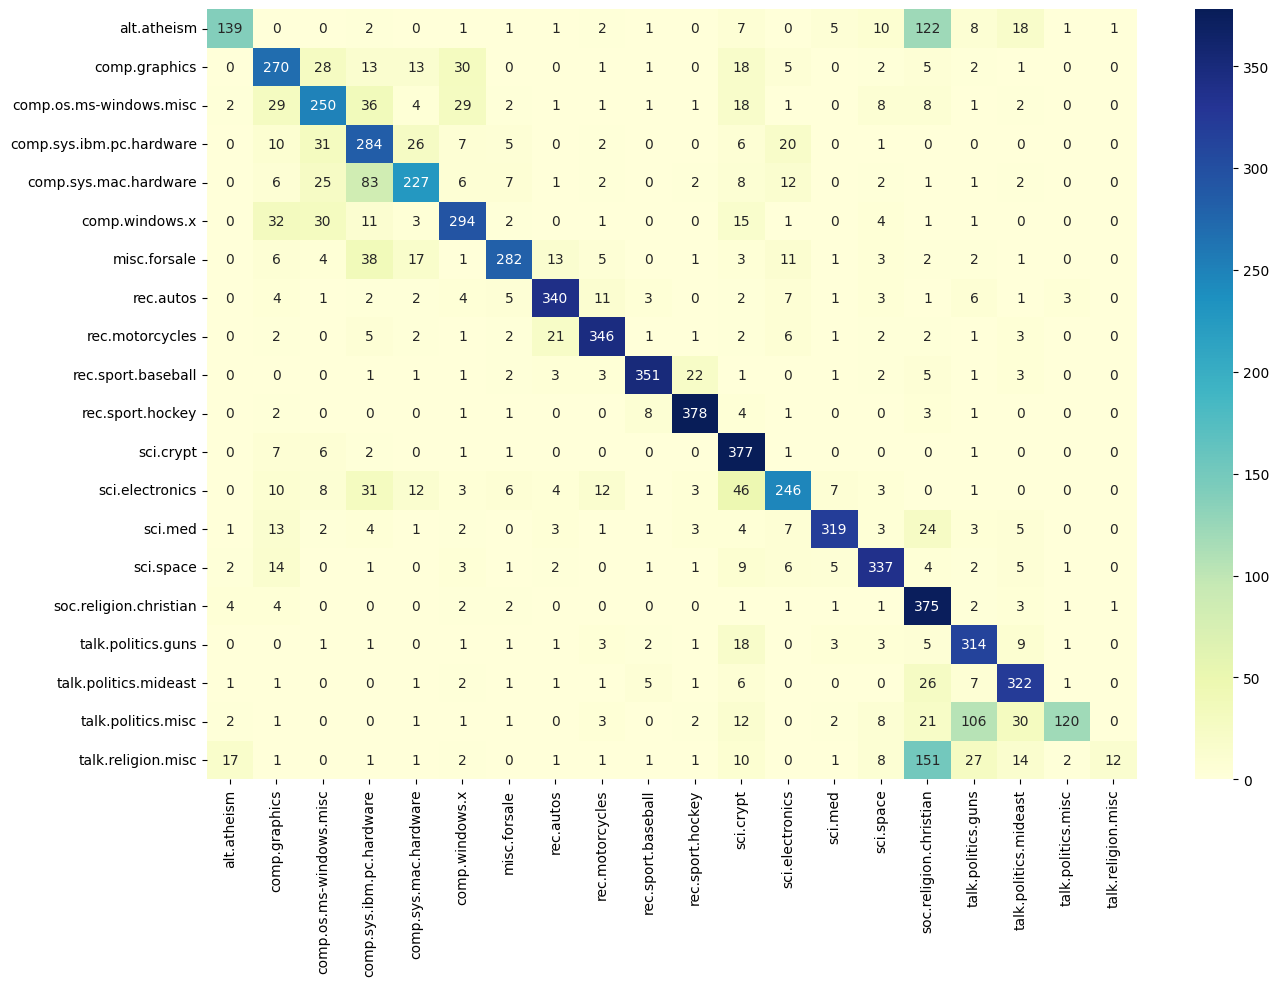

In [29]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_data.target, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=test_data.target_names, columns=test_data.target_names)

plt.figure(figsize=(15, 10))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Ahora podemos comprobar la fuente de las confusiones.
- Una fila con muchas observaciones fuera de la celda de la diagonal principal, indica una exhaustividad baja.
    - Si las observaciones se concentran en alguna celda fuera de la diagonal, indica que son clasificadas (erróneamente) como de la clase a la que pertenezca su fila. Es el caso de las observaciones de `talk.religion.misc` que son clasificadas como `soc.religion.christian`, las de `talk.politics.misc`  ques son clasificadas como `talk.politics.guns` y las de `alt.atheism` que son clasificadas como `soc.religion.christian`. Es interesante que ninguna de estas confusiones es simétrica, lo que quiere decir que, por ejemplo, los textos de `soc.religion.christian` tienen suficientes rasgos distintivos para ser diferenciados de `alt.atheism`.
- Una columna con muchas observaciones fuera de la celda de la diagonal principal, indica una una precisión baja, o una contaminación en la precisión del clasificador.
    - Es el caso de `soc.religion.christian` (o de `comp.sys.ibm.pc.hardware`) que pese a tener una exhaustividad alta (>90%) tiene una precisión baja, ya que detecta como falsos positivos muchos textos de muchos otros temas.

### Importancia de las variables

Algunos algoritmos de clasificación permiten analizar cuáles son las variables más relevantes para la clasificación. Suele ser una buena idea para entender mejor los resultados analizar esas variables. En el caso de nuestro problema, lo que nos diría sería qué palabras son más útiles para realizar la clasificación.

Este tipo de análisis es muy dependiente de la técnica que estemos utilizando, de los fundamentos en los que se base dicha técnica. De hecho, no todas las técnicas permiten hacer estos análisis ya que algunas son más "caja negra" que otras.

Como información complementaria a lo que veremos en este notebook decir que el paquete **eli5** de Python tiene como objetivo explicar las predicciones de algunos modelos de machine learning.

#### Árboles de decisión

En el caso de los árboles de decisión podemos obtener las variables con mayor poder de discriminación en el árbol obtenido, es decir, aquellas que mayor reducción de Gini han producido a lo largo del árbol.

In [30]:
def print_top20_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names_out()

    top20 = np.argsort(clf.feature_importances_)[-20:]
    reversed_top = top20[::-1]
    print("Top 20 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

In [31]:
print_top20_features_in_trees(vectorizer,tree_classifier)

Top 20 features in the tree

clipper / windows / bike / hockey / space / baseball / guns / cars / christians / organization / graphics / atheists / subject / lines / writes / turks / posting / window / team / motif


En este caso es muy claro que estamos encontrando palabras que rápidamente nos remiten a alguno de los temas de los que tratan las noticias como es el caso de `clipper` que es un [chip de criptografía](https://www.cryptomuseum.com/crypto/usa/clipper.htm), `windows` que es el sistema operativo, ``bike`` que se refiere a motos, etc.

#### Naive Bayes

En el caso del Naive Bayes, por cada una de las clases a predecir, podemos obtener aquellas palabras que es más verosímil que aparezcan.  

In [32]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]

        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')

        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [33]:
print_top20_features_per_class_in_NB(vectorizer,mnb_classifier,test_data.target_names)

Top 20 features per class

alt.atheism: atheists / writes / atheism / people / morality / article / think / religion / moral / lines / subject / posting / organization / objective / said / believe / does / mantis / evidence / know 

comp.graphics: graphics / image / lines / subject / organization / thanks / posting / file / program / ac / polygon / format / images / need / help / windows / version / looking / package / know 

comp.os.ms-windows.misc: windows / file / driver / drivers / lines / subject / organization / thanks / using / program / problem / version / access / help / know / does / mail / posting / run / article 

comp.sys.ibm.pc.hardware: drive / ide / controller / thanks / lines / subject / organization / disk / monitor / drives / motherboard / help / floppy / posting / computer / board / does / windows / gateway / problem 

comp.sys.mac.hardware: quadra / drive / lines / subject / monitor / organization / posting / thanks / does / duo / problem / know / video / computer 

En general, vemos que hay las palabras tienen bastante sentido, aunque existen otras como ``people`` que aparecen en primeras posiciones en todas los grupos de ``talk`` y que aparecen también en otros. O palabras como ``like`` que aunque pueden querer decir gustar, también pueden significar como, y que en cualquier caso parecen palabras casi vacías (otro caso similar es el de ``does`` o el de ``thanks``).

### Perceptrón multicapa

El perceptrón multicapa es también un clasificador adecuado. Sin embargo, el entrenamiento es mucho más costoso en tiempo. En este caso vamos a usar la implementación del perceptrón multicapa para problemas de clasificación.

**AVISO: Ejecutar la celda siguiente lleva varias horas**

In [ ]:
from sklearn.neural_network import MLPClassifier

# Creamos el clasificador con los valores por defecto
mlp_classifier = MLPClassifier(verbose=True)
mlp_classifier.fit(train_preprocessed, train_data.target)

mlp_train_predictions = mlp_classifier.predict(train_preprocessed)
mlp_test_predictions = mlp_classifier.predict(test_preprocessed)

print("Perceptrón, porcentaje de aciertos en entrenamiento:", np.mean(mlp_train_predictions == train_data.target))
print("Perceptrón, porcentaje de aciertos en test:", np.mean(mlp_test_predictions == test_data.target))

Iteration 1, loss = 2.79712704
Iteration 2, loss = 1.99841840
Iteration 3, loss = 1.14354107
Iteration 4, loss = 0.65377456
Iteration 5, loss = 0.41372148
Iteration 6, loss = 0.28145217
Iteration 7, loss = 0.20195517
Iteration 8, loss = 0.15041447
Iteration 9, loss = 0.11542760
Iteration 10, loss = 0.09068280
Iteration 11, loss = 0.07291312
Iteration 12, loss = 0.05973995
Iteration 13, loss = 0.04980103
Iteration 14, loss = 0.04225740
Iteration 15, loss = 0.03628163
Iteration 16, loss = 0.03163790
Iteration 17, loss = 0.02777626
Iteration 18, loss = 0.02466760
Iteration 19, loss = 0.02221614
Iteration 20, loss = 0.02012145
Iteration 21, loss = 0.01837250
Iteration 22, loss = 0.01683621
Iteration 23, loss = 0.01560559
Iteration 24, loss = 0.01451794
Iteration 25, loss = 0.01368235
Iteration 26, loss = 0.01281006
Iteration 27, loss = 0.01213643
Iteration 28, loss = 0.01157628
Iteration 29, loss = 0.01099636
Iteration 30, loss = 0.01066031
Iteration 31, loss = 0.01009790
Iteration 32, los

### Otros clasificadores

Otro clasificador que se usa en PLN es la [regresión logística](https://en.wikipedia.org/wiki/Logistic_regression) o las más sofisticadas Máquinas de Vectores de Soporte o  [Support Vector Machines](https://en.wikipedia.org/wiki/Support_vector_machine).

Por último, mencionar que existen otras corrientes más actuales que usan "aprendizaje profundo" o deep learning con aún mejores resultados.